In [9]:
import networkx as nx
from NEMtropy import UndirectedGraph, DirectedGraph
from NEMtropy.network_functions import build_adjacency_from_edgelist
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import statistics as stats
import math

In [10]:
# read data
data_path = '/Users/luojiayu/Downloads/semester1/Network Science/Assignments/Assignment6/data/World_Trade_Web/'


name_list = [
    '1992',
    '1993',
    '1994',
    '1995',
    '1999',
    '2000',
    '2001',
    '2002',
]
all_graph = dict()

for name in name_list:
    graph_real = nx.read_graphml(data_path+'WDN_'+name+'.txt.graphml')
    
    all_graph[name] = graph_real

# A06.1 - Exponential Random Graph Models

In [17]:
# ERGM
for name in all_graph:
    G = all_graph[name]
    
    G = G.to_undirected()
    
    adj_matrix = nx.to_numpy_array(G)
    
    # Undirect
    G_ubcm = UndirectedGraph(adj_matrix)
    
    G_ubcm.solve_tool(model="cm_exp")
    
    G_ubcm.ensemble_sampler(30, cpu_n=1, output_dir="sample/"+name+"/ubcm/")



solution error = 5.9955027609248646e-09

solution error = 6.892918236189871e-09

solution error = 2.150642330889241e-09

solution error = 3.1954527912603226e-10

solution error = 1.5092211924638832e-09

solution error = 2.9012312552367803e-09

solution error = 6.553136699949391e-09

solution error = 2.0831691927014617e-09


In [18]:
# ERGM
for name in all_graph:
    G = all_graph[name]
    
    adj_matrix = nx.to_numpy_array(G)
    
    # direct
    G_dbcm = DirectedGraph(adj_matrix)
    
    G_dbcm.solve_tool(model="dcm_exp")
    
    G_dbcm.ensemble_sampler(30, cpu_n=1, output_dir="sample/"+name+"/dbcm/")



solution error = 1.724401954561472e-09

solution error = 2.7393873835990235e-09

solution error = 2.5775968026664486e-09

solution error = 4.4906585117132636e-09

solution error = 3.0712214993400266e-09

solution error = 3.874504272971535e-09

solution error = 4.5587924546452996e-09

solution error = 1.702069596376532e-09


In [22]:
def get_err(model_name):
    
    # calculate error of every ERGM model

    clustering = dict()
    reciprocity = dict()
    clustering_std_err = dict()
    reciprocity_std_err = dict()
    clustering_avg_err = dict()
    reciprocity_avg_err = dict()

    for year_name in all_graph:
        G = all_graph[year_name]

        # clusting
        avg_cluster = nx.average_clustering(G)
        clustering[year_name] = avg_cluster

        # reciprocity coefficients
        if model_name == 'dbcm':
            reciprocity_coe = nx.reciprocity(G)
            reciprocity[year_name] = reciprocity_coe

        # iterator ERGM
        clustering_err_list = list()
        reciprocity_err_list = list()
        for i in range(30):
            edgelist_ens = np.loadtxt(f"sample/"+year_name+"/"+model_name+"/"+str(i)+'.txt')
            
            if model_name == 'dbcm':
                net = nx.DiGraph()
            else:
                net = nx.Graph()
            net.add_edges_from(edgelist_ens)

            # clustering
            err = avg_cluster - nx.average_clustering(net)
            clustering_err_list.append(err)
                        

            # reciprocity
            if model_name == 'dbcm':
                err = reciprocity_coe - nx.reciprocity(net)
                reciprocity_err_list.append(err)
        
        # std and avg
        clustering_std_err[year_name] = stats.stdev(clustering_err_list)
        clustering_avg_err[year_name] = stats.mean(clustering_err_list)
        if model_name == 'dbcm':
            reciprocity_std_err[year_name] = stats.stdev(reciprocity_err_list)
            reciprocity_avg_err[year_name] = stats.mean(reciprocity_err_list)
    
    return clustering, reciprocity, clustering_std_err, clustering_avg_err,\
                reciprocity_std_err, reciprocity_avg_err


def draw(err_std_dict, err_avg_dict, metrics_dict, metrics_name, model_name):
    fig, axes = plt.subplots(ncols = 2, figsize=(13, 4)) 
    
    barWidth = 0.3
    
    # std
    err = err_std_dict.values()
    bar_label = metrics_dict.keys()
    bar_value = metrics_dict.values()
    
    # avg
    scatter_key = err_avg_dict.keys()
    scatter_value = err_avg_dict.values()
    
    # confidence interval
    confidence_68 = list(err)
    confidence_95 = [i*2 for i in list(err)]
    confidence_99 = [i*3 for i in list(err)]

    axes[0].errorbar(bar_label, bar_value, yerr=confidence_95, capsize=7, label='confidence 95')
    axes[0].set(xlabel='Year', ylabel='Avg '+metrics_name)
    axes[0].set_title('{} Std Error ({})'.format(metrics_name, model_name))
    
    axes[1].scatter(scatter_key, scatter_value)
    axes[1].set(xlabel='Year', ylabel=metrics_name)
    axes[1].set_title('{} Avg  Error ({})'.format(metrics_name, model_name))
    
    

## UBCM

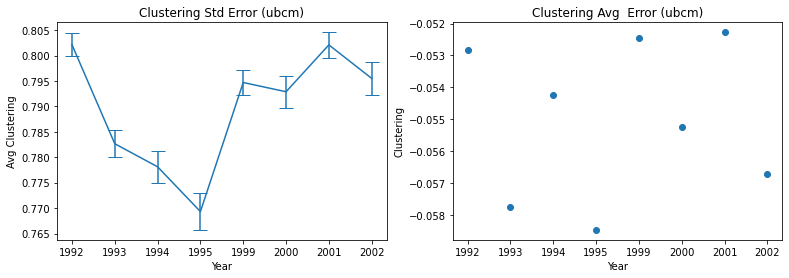

In [23]:
# calculate error
clustering_ubcm, reciprocity_ubcm, clustering_std_err_ubcm, clustering_avg_err_ubcm,\
                reciprocity_std_err_ubcm, reciprocity_avg_err_ubcm = get_err('ubcm')


# draw
draw(clustering_std_err_ubcm, clustering_avg_err_ubcm, clustering_ubcm, 'Clustering', 'ubcm')


## DBCM

In [24]:
# calculate error
clustering_dbcm, reciprocity_dbcm, clustering_std_err_dbcm, clustering_avg_err_dbcm,\
                reciprocity_std_err_dbcm, reciprocity_avg_err_dbcm = get_err('dbcm')


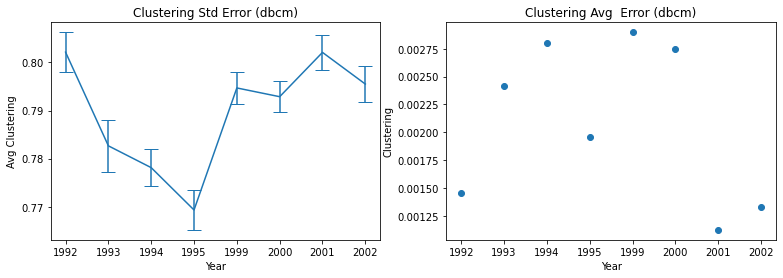

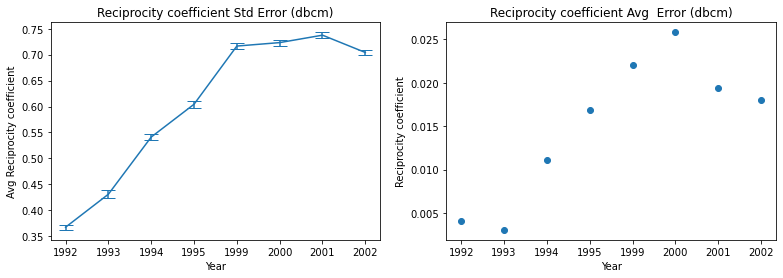

In [25]:
draw(clustering_std_err_dbcm, clustering_avg_err_dbcm, clustering_dbcm, 'Clustering', 'dbcm')
draw(reciprocity_std_err_dbcm, reciprocity_avg_err_dbcm, reciprocity_dbcm, 'Reciprocity coefficient', 'dbcm',)

# A06.2 - Weighted ERGMs

## Directed Enhanced CM

In [18]:
def draw(err_std_dict, err_avg_dict, metrics_dict, metrics_name, model_name):
    fig, axes = plt.subplots(ncols = 2, figsize=(13, 4)) 
    
    barWidth = 0.3
    
    # std
    err = err_std_dict.values()
    bar_label = metrics_dict.keys()
    bar_value = metrics_dict.values()
    
    # avg
    scatter_key = err_avg_dict.keys()
    scatter_value = err_avg_dict.values()
    
    # confidence interval
    confidence_68 = list(err)
    confidence_95 = [i*2 for i in list(err)]
    confidence_99 = [i*3 for i in list(err)]

    axes[0].errorbar(bar_label, bar_value, yerr=confidence_95, capsize=7, label='confidence 95')
    axes[0].set(xlabel='Year', ylabel='Avg '+metrics_name)
    axes[0].set_title('{} Std Error ({})'.format(metrics_name, model_name))
    
    axes[1].scatter(scatter_key, scatter_value)
    axes[1].set(xlabel='Year', ylabel=metrics_name)
    axes[1].set_title('{} Avg  Error ({})'.format(metrics_name, model_name))

In [31]:
from NEMtropy import matrix_generator
# API 
# https://nemtropy.readthedocs.io/en/1.0.5/NEMtropy.html#NEMtropy.matrix_generator.random_weighted_matrix_generator_uniform_custom_density

# ERGM (weight)
for name in all_graph:
    G = all_graph[name]
    
    adj_matrix = nx.to_numpy_array(G)

    # direct
    G_decm = DirectedGraph(adj_matrix)

    G_decm.solve_tool(
                 model="crema",
#                  method="newton",
#                  initial_guess="random",
                 adjacency="dcm_exp",
#                  method_adjacency="newton"
                     )
    
    G_decm.ensemble_sampler(30, cpu_n=1, output_dir="sample/weight/"+name+"/decm/")


In [20]:
def get_err_decm(model_name, x, y):
    
    # calculate error of every ERGM model

    assortativity_dict = dict()
    assortativity_std_err = dict()
    assortativity_avg_err = dict()

    for year_name in all_graph:
        G = all_graph[year_name]

        # assortativity
        assortativity = nx.degree_pearson_correlation_coefficient(G, x=x, y=y, weight='weight')
        assortativity_dict[year_name] = assortativity

        # iterator ERGM
        assortativity_err_list = list()
        for i in range(30):
            
            edgelist_ens = np.loadtxt(f"sample/weight/"+year_name+"/"+model_name+"/"+str(i)+'.txt')
            
            ens_adj = build_adjacency_from_edgelist(edgelist = edgelist_ens,
                                                    is_directed = True,
                                                    is_sparse = False,
                                                    is_weighted = True)
            net = nx.from_numpy_array(ens_adj)
        
            # clustering
            err = assortativity - nx.degree_pearson_correlation_coefficient(net, x=x, y=y, weight='weight')
            assortativity_err_list.append(err)
        
        # std and avg
        assortativity_std_err[year_name] = stats.stdev(assortativity_err_list)
        assortativity_avg_err[year_name] = stats.mean(assortativity_err_list)

    
    return assortativity_dict, assortativity_std_err, assortativity_avg_err


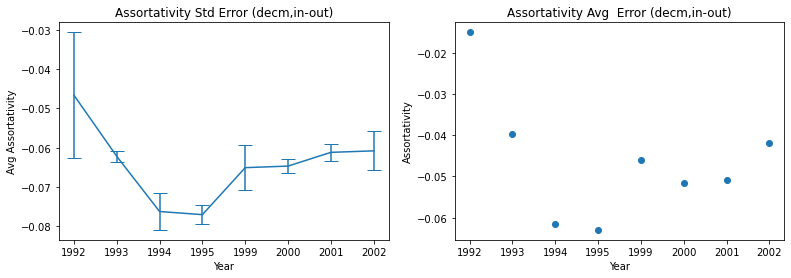

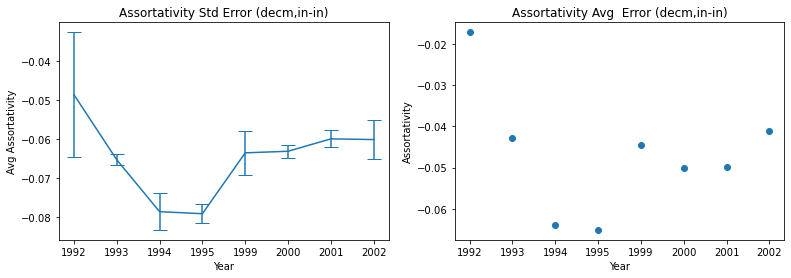

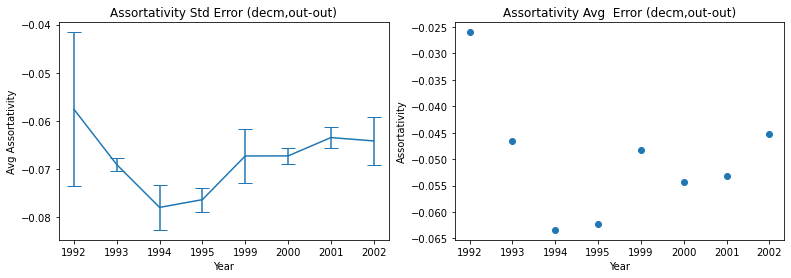

In [21]:
# in-out
assortativity_dict_1, assortativity_std_err_1, assortativity_avg_err_1 = get_err_decm('decm', 'in', 'out')
draw(assortativity_std_err_1, assortativity_avg_err_1,assortativity_dict_1, 'Assortativity', 'decm,in-out')

# in-in
assortativity_dict_2, assortativity_std_err_2, assortativity_avg_err_2 = get_err_decm('decm', 'in', 'in')
draw(assortativity_std_err_2, assortativity_avg_err_2,assortativity_dict_2, 'Assortativity', 'decm,in-in')

# out-out
assortativity_dict_3, assortativity_std_err_3, assortativity_avg_err_3 = get_err_decm('decm', 'out', 'out')
draw(assortativity_std_err_3, assortativity_avg_err_3, assortativity_dict_3, 'Assortativity', 'decm,out-out')

## Undirected Enhanced CM

In [32]:
from NEMtropy import matrix_generator
# API 
# https://nemtropy.readthedocs.io/en/1.0.5/NEMtropy.html#NEMtropy.matrix_generator.random_weighted_matrix_generator_uniform_custom_density

# ERGM (weight)
for name in all_graph:
    G = all_graph[name]
    
    G = G.to_undirected()
    
    adj_matrix = nx.to_numpy_array(G)
    
    # Undirect 
    G_uecm = UndirectedGraph(adj_matrix)

    G_uecm.solve_tool(
                    model="crema",
#                      method="newton",
#                      initial_guess="random",
                     adjacency="cm_exp",
#                      method_adjacency="newton"
                     )
    G_uecm.ensemble_sampler(30, cpu_n=1, output_dir="sample/weight/"+name+"/uecm/")
    

In [29]:
from NEMtropy import matrix_generator
def get_err_uecm(model_name, x, y):
    
    # calculate error of every ERGM model

    assortativity_dict = dict()
    assortativity_std_err = dict()
    assortativity_avg_err = dict()

    for year_name in all_graph:
        G = all_graph[year_name]
        
        # assortativity
        assortativity = nx.degree_pearson_correlation_coefficient(G, weight='weight')
        assortativity_dict[year_name] = assortativity    

        # iterator ERGM
        assortativity_err_list = list()
        for i in range(30):
            
            edgelist_ens = np.loadtxt(f"sample/weight/"+year_name+"/"+model_name+"/"+str(i)+'.txt')
            
            ens_adj = build_adjacency_from_edgelist(edgelist = edgelist_ens,
                                                    is_directed = False,
                                                    is_sparse = False,
                                                    is_weighted = True)
            net = nx.from_numpy_array(ens_adj)

            # clustering
            err = assortativity - nx.degree_pearson_correlation_coefficient(net, weight='weight')
            assortativity_err_list.append(err)

        
        # std and avg
        assortativity_std_err[year_name] = stats.stdev(assortativity_err_list)
        assortativity_avg_err[year_name] = stats.mean(assortativity_err_list)

    
    return assortativity_dict, assortativity_std_err, assortativity_avg_err


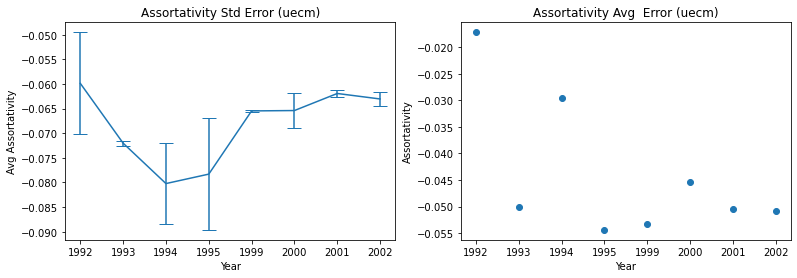

In [30]:
assortativity_dict_uecm, assortativity_std_err_uecm, assortativity_avg_err_uecm = get_err_uecm('uecm','none','none')

draw(assortativity_std_err_uecm, assortativity_avg_err_uecm, assortativity_dict_uecm, 'Assortativity', 'uecm')

# A06.3 - Drawing conclusions

###  (1) clustering and reciprocity coefficients

- Exponential Random Graph Models use maximum likelihood to define a model. This is a flexible way to introduce dependencies.
- Unlike the Erdos-Renyi model which misses many real-world features( e.g. clusting), ERGM generates models well. The clustering error is low (especially in Direct Graph).
- Reciprocity is a measure of the likelihood of vertices in a directed network to be mutually linked. Since the likelihood in ERGM partly depends on whether nodes have friends in common. The new graph generated by ERGM has low errors too.



###  (2) strength assortativity

- Assortativity measures the similarity of connections in the graph with respect to the node degree.
New graphs generated by decm have stable performance.

###  (3) UBCM, DBCM and DECM models

- All these models allow us to generate random graphs from the original one. They all base on null models and identify original graphs' patterns (clusting, communication).